In [1]:
# league quality


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import boxball_loader as bbl
import baseball_stats_utils as bsu

In [3]:
tms = bbl.load_teams()

In [4]:
cols = ['bat_team_id', 'fld_team_id', 'bat_id', 'pit_id', 'bat_fld_cd', 'bat_event_fl', 'bat_hand_cd', 'pit_hand_cd', 'event_cd']
pa = bbl.load_event_data(1997, 2020, cols).query('bat_fld_cd != 1')
pa.shape

(4212969, 17)

In [5]:
# Merge the lg_ids in, for the bat_team and fld_team
pa = pd.merge(left=pa, right=tms[['yr', 'team_id_retro', 'lg_id']].rename(columns={'team_id_retro': 'bat_team_id', 'lg_id': 'bat_lg_id'}))
pa = pd.merge(left=pa, right=tms[['yr', 'team_id_retro', 'lg_id']].rename(columns={'team_id_retro': 'fld_team_id', 'lg_id': 'fld_lg_id'}))
pa.shape

(4212969, 19)

In [6]:
# Add ages to each PA, to see if perhaps there's a bias of older players in the samples
# Also look at whether the player was in "prime" age
# For now, consider prime to be 24-30
ppl = bbl.load_people()
bat_birth_yrs = pd.merge(left=pa, right=ppl[['retro_id', 'birth_year']].rename(columns={'retro_id': 'bat_id'}))['birth_year']
pit_birth_yrs = pd.merge(left=pa, right=ppl[['retro_id', 'birth_year']].rename(columns={'retro_id': 'pit_id'}))['birth_year']

prime_age_range = range(24, 31)
pa['bat_age'] = pa['date'].dt.year - bat_birth_yrs
pa['pit_age'] = pa['date'].dt.year - pit_birth_yrs
pa['bat_prime_age'] = pa['bat_age'].isin(prime_age_range)
pa['pit_prime_age'] = pa['pit_age'].isin(prime_age_range)

pa.sample(20)

,game_id,date,game_type,tb_ct,bat_fld_cd,event_cd,bat_event_fl,fld_team_id,pit_hand_cd,pit_id,...,ab_fl,h_fl,ob_fl,yr,bat_lg_id,fld_lg_id,bat_age,pit_age,bat_prime_age,pit_prime_age
1534286,MIN200509030,2005-09-03,RS,0,8,14,True,CLE,R,millk004,...,False,0,1,2005,AL,AL,32.0,29.0,False,True
419933,LAN199907290,1999-07-29,RS,1,8,20,True,CIN,L,whitg001,...,True,1,1,1999,NL,NL,28.0,30.0,True,True
1100989,NYA200309060,2003-09-06,RS,0,3,14,True,BOS,R,waket001,...,False,0,1,2003,AL,AL,38.0,36.0,False,False
115878,CHA199704170,1997-04-17,RS,0,5,2,True,CHA,R,darwd001,...,True,0,0,1997,AL,AL,22.0,30.0,False,True
3311152,ARI201508300,2015-08-30,RS,0,11,2,True,ARI,R,ziegb001,...,True,0,0,2015,AL,NL,29.0,28.0,True,True
3909822,DET201807050,2018-07-05,RS,2,2,21,True,TEX,L,diekj001,...,True,1,1,2018,AL,AL,26.0,27.0,True,True
2801715,SFN201209250,2012-09-25,RS,0,8,3,True,SFN,R,pennb002,...,True,0,0,2012,NL,NL,29.0,27.0,True,True
2644573,TBA201104290,2011-04-29,RS,0,3,3,True,ANA,R,sante001,...,True,0,0,2011,AL,AL,30.0,29.0,True,True
1191977,NYA200305170,2003-05-17,RS,0,3,2,True,TEX,R,valdi001,...,True,0,0,2003,AL,AL,29.0,25.0,True,True
1588646,LAN200507310,2005-07-31,RS,0,5,2,True,LAN,L,pereo001,...,True,0,0,2005,NL,NL,33.0,29.0,False,True


In [7]:
pa.columns

Index(['game_id', 'date', 'game_type', 'tb_ct', 'bat_fld_cd', 'event_cd',
       'bat_event_fl', 'fld_team_id', 'pit_hand_cd', 'pit_id', 'bat_team_id',
       'bat_hand_cd', 'bat_id', 'ab_fl', 'h_fl', 'ob_fl', 'yr', 'bat_lg_id',
       'fld_lg_id', 'bat_age', 'pit_age', 'bat_prime_age', 'pit_prime_age'],
      dtype='object')

In [8]:
bsu.summarize_events(pa, ['bat_lg_id', 'fld_lg_id'])

pa      ob       ab       h        tb       k  \
bat_lg_id fld_lg_id                                                       
AL        AL         1836993  594252  1642851  432120  694173.0  332027   
          NL          237262   77857   211674   56523   91398.0   42644   
NL        AL          236497   75454   211985   55246   88442.0   44571   
          NL         1902217  622525  1690864  448721  721063.0  341740   

                         bb    ibb     hr        ba       obp       slg  \
bat_lg_id fld_lg_id                                                       
AL        AL         145341   8931  53228  0.263031  0.323492  0.422542   
          NL          19206   1460   7109  0.267029  0.328148  0.431787   
NL        AL          17940   1457   6717  0.260613  0.319048  0.417209   
          NL         155667  14917  54002  0.265380  0.327263  0.426446   

                         woba        k%       bb%       hr%  
bat_lg_id fld_lg_id                                          
AL        AL         0.315632  0.180745  0.079119  0.028976  
          NL         0.320515  0.179734  0.080948  0.029963  
NL        AL         0.310874  0.188463  0.075857  0.028402  
          NL         0.317439  0.179654  0.081835  0.028389

In [9]:
df = pa[(pa['yr'].isin(range(2010, 2015)))]
bsu.summarize_events(df, ['bat_lg_id', 'fld_lg_id'])

pa      ob      ab      h        tb      k     bb  \
bat_lg_id fld_lg_id                                                          
AL        AL         392723  123395  352725  90293  142424.0  74452  29789   
          NL          49920   16012   44834  11831   18523.0   8873   3778   
NL        AL          49546   15200   44802  11369   17836.0   9859   3360   
          NL         402796  128129  360878  93783  146575.0  76019  30827   

                      ibb     hr        ba       obp       slg      woba  \
bat_lg_id fld_lg_id                                                        
AL        AL         1959  10319  0.255987  0.314204  0.403782  0.304489   
          NL          305   1325  0.263885  0.320753  0.413146  0.310296   
NL        AL          315   1230  0.253761  0.306786  0.398107  0.297802   
          NL         2926   9968  0.259875  0.318099  0.406162  0.306177   

                           k%       bb%       hr%  
bat_lg_id fld_lg_id                                
AL        AL         0.189579  0.075852  0.026276  
          NL         0.177744  0.075681  0.026542  
NL        AL         0.198987  0.067816  0.024825  
          NL         0.188728  0.076533  0.024747

In [10]:
split = bsu.summarize_events(pa, ['bat_id', 'fld_lg_id'])
split

pa   ob    ab    h   tb    k   bb  ibb  hr        ba  \
bat_id   fld_lg_id                                                           
abada001 AL           20    4    18    2    2    5    2    0   0  0.111111   
         NL            5    2     3    0    0    0    2    0   0  0.000000   
abboj002 AL          549  160   502  129  209   75   29    2  18  0.256972   
         NL          102   36    94   28   39   16    7    0   0  0.297872   
abbok002 AL          208   67   185   50   75   57   15    1   4  0.270270   
...                  ...  ...   ...  ...  ...  ...  ...  ...  ..       ...   
zubej001 NL           47   17    40   10   18    8    6    0   1  0.250000   
zulej001 AL           14    4    13    3    4    2    0    0   0  0.230769   
         NL          177   54   161   40   77   49    9    1   9  0.248447   
zunim001 AL         2137  570  1934  386  767  732  141    0  97  0.199586   
         NL          323   90   292   60  109  117   22    1  11  0.205479   

                         obp       slg      woba        k%       bb%       hr%  
bat_id   fld_lg_id                                                              
abada001 AL         0.200000  0.111111  0.156400  0.250000  0.100000  0.000000  
         NL         0.400000  0.000000  0.280800  0.000000  0.400000  0.000000  
abboj002 AL         0.291439  0.416335  0.294618  0.136612  0.052823  0.032787  
         NL         0.352941  0.414894  0.331588  0.156863  0.068627  0.000000  
abbok002 AL         0.322115  0.405405  0.307159  0.274038  0.072115  0.019231  
...                      ...       ...       ...       ...       ...       ...  
zubej001 NL         0.361702  0.450000  0.350936  0.170213  0.127660  0.021277  
zulej001 AL         0.285714  0.307692  0.261286  0.142857  0.000000  0.000000  
         NL         0.305085  0.478261  0.325545  0.276836  0.050847  0.050847  
zunim001 AL         0.266729  0.396587  0.282110  0.342536  0.065980  0.045391  
         NL         0.278638  0.373288  0.280149  0.362229  0.068111  0.034056  

[5667 rows x 16 columns]

In [11]:
def summarize_split(split, stat):
    df = split[['pa', stat]].unstack()
    min_pa = df['pa'].apply(lambda x: min(x), axis=1).rename('min_pa')
    return pd.concat([min_pa, df[stat]], axis=1).dropna()

df = summarize_split(split, 'woba')
df.sort_values('min_pa')


,min_pa,AL,NL
bat_id,,,
cahit001,1.0,0.000000,0.000000
guerg001,1.0,0.862000,0.166706
gruld001,1.0,0.000000,0.233000
rohrd001,1.0,0.399000,0.000000
gregt001,1.0,0.000000,0.302737
...,...,...,...
cabro001,4037.0,0.297790,0.297248
guerv001,4300.0,0.354498,0.369267
belta001,4440.0,0.332829,0.339237


In [12]:
[(df['min_pa']*df[lg]).sum()/df['min_pa'].sum() for lg in ['AL', 'NL']]

[0.31160036736837976, 0.3171716870611606]

In [13]:
def compute_overall_split(df_pa, split, stat):
    df = summarize_split(bsu.summarize_events(df_pa, split), stat)
    return ({lg: (df['min_pa']*df[lg]).sum()/df['min_pa'].sum() for lg in ['AL', 'NL']})

compute_overall_split(pa, ['bat_id', 'fld_lg_id'], 'woba')


{'AL': 0.31160036736837976, 'NL': 0.3171716870611606}

In [14]:

def compute_splits_windows(df_pa, split, window_size):
    stat = 'woba'
    def compute_split_range(df_pa, yr):
        rng = range(yr, yr+window_size)
        return compute_overall_split(df_pa.query('yr in @rng'), split, stat)


    yrs = range(df_pa['yr'].min(), df_pa['yr'].max()-window_size+1)
    result = pd.DataFrame({yr: compute_split_range(df_pa, yr) for yr in yrs}).T
    stacked = result.stack().rename(stat)
    stacked.index.names= ['yr', split[1]]
    return stacked


In [15]:

# First look at a pool of batters, comparing the pitching/fielding of each league

result = compute_splits_windows(pa, split = ['bat_id', 'fld_lg_id'], window_size = 5)
fig = px.line(result.reset_index(), x='yr', y='woba', color='fld_lg_id')
fig.update_layout(hovermode="x")
fig.show()
result.unstack()

    

fld_lg_id,AL,NL
yr,,
1997,0.319909,0.322970
1998,0.319015,0.322138
1999,0.318328,0.321597
2000,0.315595,0.319481
2001,0.312926,0.318310
2002,0.313391,0.321513
2003,0.312846,0.323768
2004,0.311629,0.323648
2005,0.310870,0.322083


<AxesSubplot:xlabel='yr'>

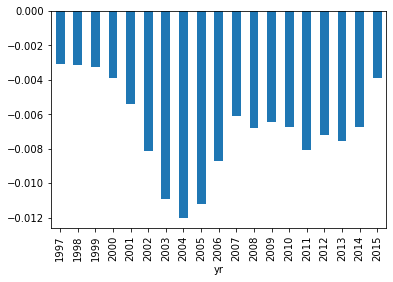

In [16]:
# The AL's pitchers have been consistently better
(result.unstack()['AL']-result.unstack()['NL']).plot.bar()

In [17]:
# Now look at a pool of pitchers, comparing the offenses of each league

result = compute_splits_windows(pa, split = ['pit_id', 'bat_lg_id'], window_size = 5)
fig = px.line(result.reset_index(), x='yr', y='woba', color='bat_lg_id')
fig.update_layout(hovermode="x")
fig.show()
result.unstack()

bat_lg_id,AL,NL
yr,,
1997,0.329435,0.325855
1998,0.328564,0.323626
1999,0.328658,0.323719
2000,0.326252,0.320971
2001,0.322174,0.316259
2002,0.322420,0.315818
2003,0.324368,0.317684
2004,0.325346,0.318381
2005,0.324650,0.317097


In [18]:
# Do the same thing, while ignoring DHs/PHs/etc
pos_range = range(2, 9)

result = compute_splits_windows(pa.query('bat_fld_cd in @pos_range'), split = ['pit_id', 'bat_lg_id'], window_size = 5)
fig = px.line(result.reset_index(), x='yr', y='woba', color='bat_lg_id')
fig.update_layout(hovermode="x")
fig.show()
result.unstack()

bat_lg_id,AL,NL
yr,,
1997,0.325412,0.325381
1998,0.325378,0.322238
1999,0.326273,0.322138
2000,0.324987,0.319413
2001,0.321018,0.314966
2002,0.320584,0.315094
2003,0.322446,0.318081
2004,0.323301,0.319392
2005,0.322245,0.318125


In [20]:
# look at who contributes to a sample and how

yr = 2004
rng = range(yr, yr+5)
df_pa = pa[(pa['bat_fld_cd']!= 1) & (pa['yr'].isin(rng))]
df = summarize_split(bsu.summarize_events(df_pa, ['bat_id', 'fld_lg_id']), 'woba')
df.sort_values('min_pa', ascending=False).head(20)

,min_pa,AL,NL
bat_id,,,
abreb001,1707.0,0.366928,0.367497
kendj001,1511.0,0.294297,0.304091
overl001,1338.0,0.324431,0.354980
soria001,1331.0,0.328951,0.358925
lowem001,1292.0,0.334049,0.338253
glaut001,1278.0,0.354172,0.369155
rente001,1276.0,0.308743,0.331212
rowaa001,1246.0,0.327464,0.341981
bellr002,1242.0,0.316449,0.330739


In [21]:

age_split = pa.groupby(['bat_id', 'fld_lg_id']).agg(pa=('event_cd', len), mean_age=('bat_age', np.mean), pct_prime=('bat_prime_age', np.mean))
age_split

pa   mean_age  pct_prime
bat_id   fld_lg_id                            
abada001 AL           20  30.000000   0.700000
         NL            5  30.000000   0.600000
abboj002 AL          549  29.342441   0.542805
         NL          102  30.196078   0.519608
abbok002 AL          208  27.543269   0.562500
...                  ...        ...        ...
zubej001 NL           47  27.468085   0.787234
zulej001 AL           14  34.571429   0.071429
         NL          177  32.005650   0.519774
zunim001 AL         2137  27.856809   0.865232
         NL          323  28.724458   0.727554

[5667 rows x 3 columns]

In [22]:
df = summarize_split(age_split, 'mean_age')
({lg: (df['min_pa']*df[lg]).sum()/df['min_pa'].sum() for lg in ['AL', 'NL']})

{'AL': 29.333670035091366, 'NL': 29.37274736626806}

In [23]:
df = summarize_split(age_split, 'pct_prime')
({lg: (df['min_pa']*df[lg]).sum()/df['min_pa'].sum() for lg in ['AL', 'NL']})

{'AL': 0.7225328273188006, 'NL': 0.6993362706992577}